#Model 5 (ResNet18 + Siamese)

In [ ]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
import os
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow as tf
from tensorflow.keras.backend import max, mean, sqrt, square, sum

import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.models import Model

from tensorflow import keras
from keras.layers import LeakyReLU, Softmax
from keras.layers import Conv2D, Activation, Input,Dropout,Lambda,Flatten, Dense
from keras.layers import Dense, Flatten, Reshape, Activation
from keras.layers import BatchNormalization ,ZeroPadding2D

from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import one_hot, reshape


from tensorflow.keras.layers import Activation, Add, AvgPool2D, BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
from numpy import rint
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from numpy import expand_dims
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow import one_hot, reshape
from keras.layers import BatchNormalization
import cv2

# from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with tf.device('/device:GPU:0'):
  colab = True
  # database = 'bigsig260_224x224_siamese_preprocessed.h5'
  if colab:
      # from google.colab import drive
      # drive.mount('/content/gdrive')
      file = '/content/drive/MyDrive/bigsig260224x224x1_siamese_preprocessed.h5'
  else:
      file = os.path.join(os.getcwd(),'RoboticLab', database)
  print(file)
  with File(file, 'r') as hdf:
      S1 = np.array(hdf.get('S1'))
      S2 = np.array(hdf.get('S2'))
      Y = np.array(hdf.get('Y'))
  print(S1.shape)
  print(S2.shape)
  print(Y.shape)

/content/drive/MyDrive/bigsig260224x224x1_siamese_preprocessed.h5
(29880, 224, 224, 1)
(29880, 224, 224, 1)
(29880, 1)


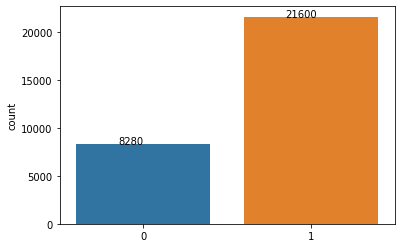

In [ ]:
ax = sns.countplot(x = Y.reshape(Y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
21600/(21600 + 8280)

0.7228915662650602

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(Y),y = Y.reshape(Y.shape[0]))
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.8043478260869565, 1: 0.6916666666666667}

In [ ]:
Y = Y/1.0

In [ ]:
S1.dtype

dtype('uint8')

In [ ]:
with tf.device('/device:GPU:0'):
  seed=randint(10)
  print('seed='+str(seed))
  indices = permutation(Y.shape[0])
  m = int(0.70 * Y.shape[0])
  n = int(0.15 * Y.shape[0])
  training_id, validation_id, test_id = indices[:m], indices[m: m + n], indices[m+n:]
  S1_train, S1_test, S1_validate = S1[training_id], S1[test_id], S1[validation_id]
  S2_train, S2_test, S2_validate = S2[training_id], S2[test_id], S2[validation_id]
  Y_train, Y_test, Y_validate = Y[training_id], Y[test_id], Y[validation_id]
  print(S1_train.shape)
  print(S2_train.shape)
  print(Y_train.shape)

  del S1,S2,Y

seed=8
(20916, 224, 224, 1)
(20916, 224, 224, 1)
(20916, 1)


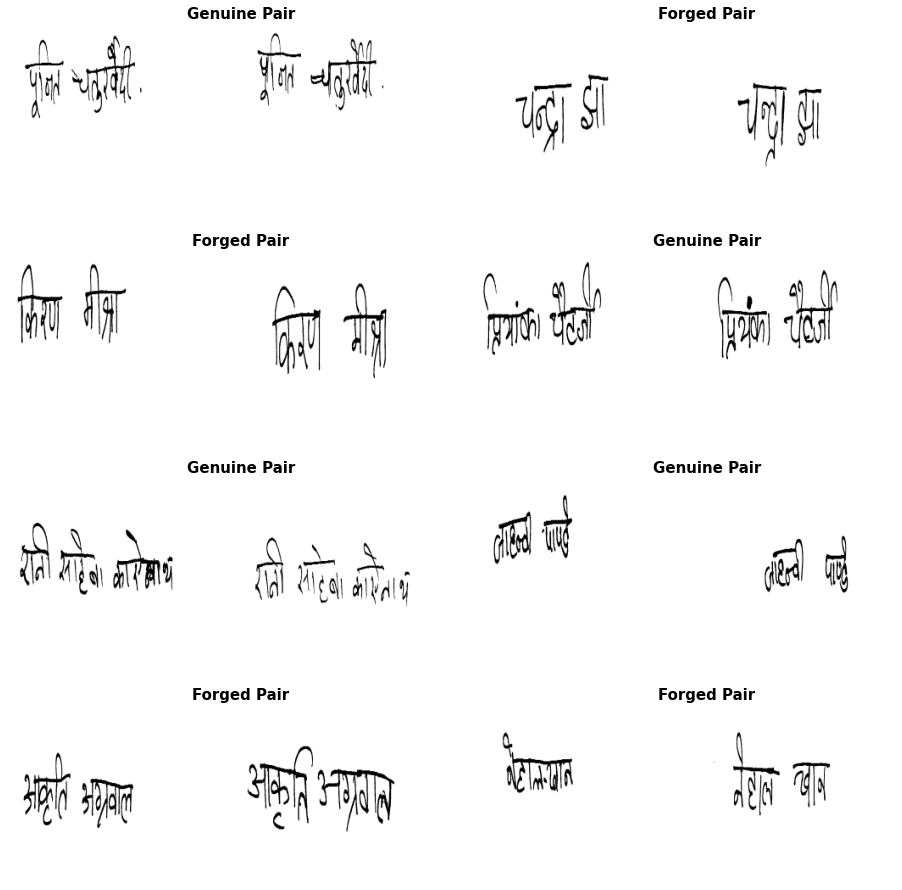

In [ ]:
fig = plt.figure(figsize = (16,16))
rows,cols = 4,4
i = 1
while(i in range(1,rows*cols)):
  random_idx = randint(0,len(S1_train))
  if(Y_train[random_idx] == 0):
    Label = "Genuine Pair"
  else:
    Label = "Forged Pair"
  img1 = S1_train[random_idx]
  img2 = S2_train[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img1.squeeze(),cmap = "gray");
  plt.axis(False);
  i += 1
  fig.add_subplot(rows,cols,i)
  plt.imshow(img2.squeeze(),cmap = "gray");
  plt.axis(False);
  plt.text(0.5, 0.5, Label, horizontalalignment='center',verticalalignment='center',fontsize=15,fontweight = 1000);
  i += 1

In [ ]:
Y_train[0]

array([0.])

In [ ]:
# #One hot Encoding
# Y_train = one_hot(Y_train, depth=2)
# Y_train = reshape(Y_train, (-1, 2))

# Y_test = one_hot(Y_test, depth=2)
# Y_test = reshape(Y_test, (-1, 2))

# Y_validate = one_hot(Y_validate, depth=2)
# Y_validate = reshape(Y_validate, (-1, 2))

In [ ]:
Y_train[0]

array([0.])

In [ ]:
Y_train.shape

(20916, 1)

In [ ]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "glorot_uniform"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,kernel_initializer="glorot_uniform")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2)
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = AvgPool2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
input_shape=(224,224,1)
input_shape

(224, 224, 1)

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

In [ ]:
def constructive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    y_true = tf.cast(y_true, y_pred.dtype)
    squaredPreds = K.square(y_pred)
    squaredMargin = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * squaredMargin + (1 - y_true) * squaredPreds)
    return loss

In [ ]:
with tf.device('/device:GPU:0'):
  inputShape = S1_train.shape[1:]
  f = ResNet18(num_classes = 2)
  f.build((None,224,224,1))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
# network definition
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = f(input_a)
processed_b = f(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a,processed_b])

model = Model(inputs = [input_a, input_b], outputs = distance)

In [ ]:
pred = model([expand_dims(S1_train[0],axis = 0), expand_dims(S2_train[0],axis = 0)])
print(pred.shape)
pred

(1, 1)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.32704693]], dtype=float32)>

## **HYPER PARAMETER TUNING**

### **LEARNING RATE**

In [ ]:
batch_Size = 32

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-03
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
          validation_data = ([S1_validate,S2_validate],Y_validate),
          epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict
            )

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-04
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict
                        )

For learning Rate =  0.0001
Epoch 1/5
559/654 [========================>.....] - ETA: 19s - loss: 0.2939 - binary_accuracy: 0.6672

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-05
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict
                        )

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-06
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy' ])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict
                        )

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-07
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict
                        )

## **FINAL TRAINING**

***BEST LEARNING RATE IS 1e-04***

In [ ]:
folder = '/content/drive/MyDrive/ResNet18(1e-04)Hindi224x224x1Inversed'

In [ ]:
Batch_size = 32
lr = 1e-04
Epochs = 30

In [ ]:
with tf.device('/device:GPU:0'):
    rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
    model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(folder + '/Weights/resnet18-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
with tf.device('/device:GPU:0'):
  results = model.fit(x = [S1_train, S2_train],y = Y_train,
                    validation_data = ([S1_validate,S2_validate],Y_validate),
                    epochs = Epochs,
                    callbacks = callbacks,
                    batch_size = Batch_size,
                    class_weight = class_weight_dict
                    )

Epoch 1/30
654/654 [==============================] - ETA: 0s - loss: 0.2708 - binary_accuracy: 0.6890
Epoch 1: saving model to /content/drive/MyDrive/ResNet18(1e-04)Hindi224x224x1Inversed/Weights/resnet18-bhsig260-001.h5
654/654 [==============================] - 155s 227ms/step - loss: 0.2708 - binary_accuracy: 0.6890 - val_loss: 0.3778 - val_binary_accuracy: 0.5694 - lr: 1.0000e-04
Epoch 2/30
654/654 [==============================] - ETA: 0s - loss: 0.0354 - binary_accuracy: 0.9552
Epoch 2: saving model to /content/drive/MyDrive/ResNet18(1e-04)Hindi224x224x1Inversed/Weights/resnet18-bhsig260-002.h5
654/654 [==============================] - 143s 219ms/step - loss: 0.0354 - binary_accuracy: 0.9552 - val_loss: 0.6919 - val_binary_accuracy: 0.2947 - lr: 1.0000e-04
Epoch 3/30
654/654 [==============================] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9872
Epoch 3: saving model to /content/drive/MyDrive/ResNet18(1e-04)Hindi224x224x1Inversed/Weights/resnet18-bhsig260-003.h5
65

In [ ]:
# Y_train.shape

In [ ]:
import pickle

In [ ]:
# with open(folder  + '/trainHistoryDict.h5', 'wb') as file_pi:
#        pickle.dump(results, file_pi)
# # model.save(folder + 'BestModel.h5')

In [ ]:
import pickle
results = pickle.load(open(folder + '/trainHistoryDict', "rb"))

In [ ]:
best_result = results.history['val_loss'].index(min(results.history['val_loss'])) + 1
best_result

12

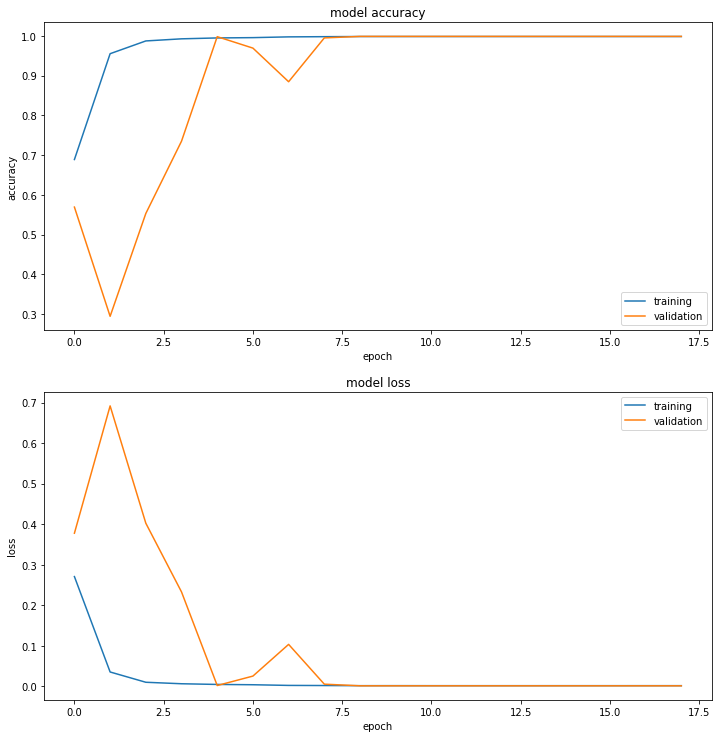

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(results.history['binary_accuracy'], results.history['val_binary_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)
plt.savefig(folder + "loss_accuracy.svg",dpi = 1200)

In [ ]:
best_result = 12
if(best_result < 10):
  model.load_weights(folder + f'/Weights/resnet18-bhsig260-00{best_result}.h5')
else:
  model.load_weights(folder + f'/Weights/resnet18-bhsig260-0{best_result}.h5')

In [ ]:
# if we keep threshold as 0.99
threshold = 0.99

In [ ]:
y_pred_keras = model.predict([S1_test, S2_test])

141/141 [==============================] - 17s 63ms/step


In [ ]:
y_pred_keras_new = np.zeros((len(y_pred_keras), 1), dtype = np.uint8)
for i in range(len(y_pred_keras)):
  label = Y_test[i]
  if y_pred_keras[i] >= threshold:
    predicted_value = 1 # both different
    if(label == predicted_value):
      y_pred_keras_new[i] = label
    else:
       y_pred_keras_new[i] = predicted_value
  else:
      predicted_value = 0
      if(label == predicted_value):
        y_pred_keras_new[i] = label
      else:
          y_pred_keras_new[i] = predicted_value

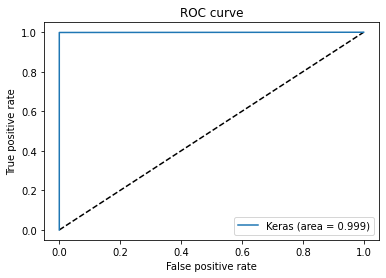

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras_new)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(folder + "roc.svg",dpi = 1200)
plt.show()

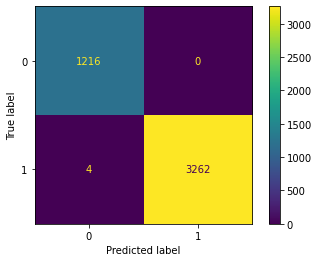

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,y_pred_keras_new)).plot()
plt.savefig(folder + "confusionmatrix.svg",dpi = 1200)
plt.show()

#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
def predict_score(i = 0):
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = ([S1_test[i],S2_test[i]],Y_test[i])
    (img1, img2), label = test_gen

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if label == 0:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([np.expand_dims(a = img1,axis = 0), np.expand_dims(a = img2,axis = 0)])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff >= threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

In [ ]:
def test_accuracy(threshold = 1):
    '''Predict distance score and classify test images as Genuine or Forged'''
    predicted_values = []
    for i in range(len(S1_test)):
      test_gen = ([S1_test[i],S2_test[i]],Y_test[i])
      (img1, img2), label = test_gen
      result = model.predict([np.expand_dims(a = img1,axis = 0), np.expand_dims(a = img2,axis = 0)])
      diff = result[0][0]
      if diff >= threshold:
          predicted_value = 1 # both different
          if(label == predicted_value):
            predicted_values.append(True) # append True for correct value else false
          else:
            predicted_values.append(False)
      elif(diff < threshold):
          predicted_value = 0 # both same so diff. between them is 0
          if(label == predicted_value):
            predicted_values.append(True) # append True for correct value else false
          else:
            predicted_values.append(False)
    correct_prediction = predicted_values.count(True)
    return (correct_prediction/len(S1_test))*100,predicted_values

In [ ]:
test_acc,predicted_labels = test_accuracy(threshold = threshold)

In [ ]:
test_acc

99.91075412762159

In [ ]:
predicted_labels.count(True)/len(Y_test)*100

99.91075412762159

In [ ]:
predicted_labels.count(False)

4

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

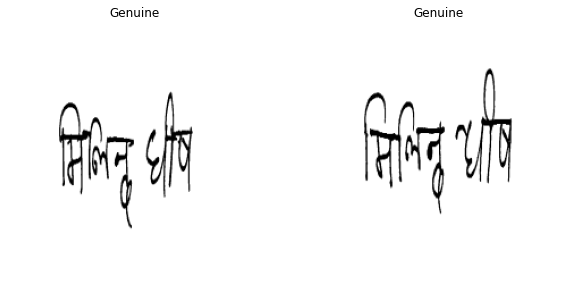

1/1 [==============================] - 0s 25ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(0)

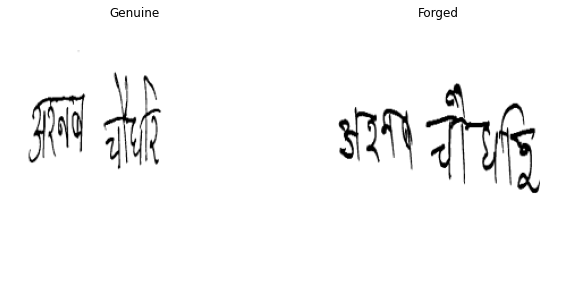

1/1 [==============================] - 0s 22ms/step
Difference Score =  0.9999996
Its a Forged Signature


In [ ]:
predict_score(1)

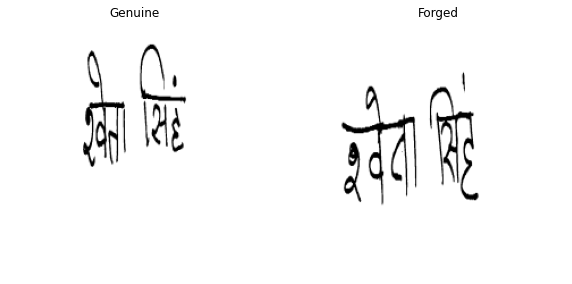

1/1 [==============================] - 0s 23ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(2)

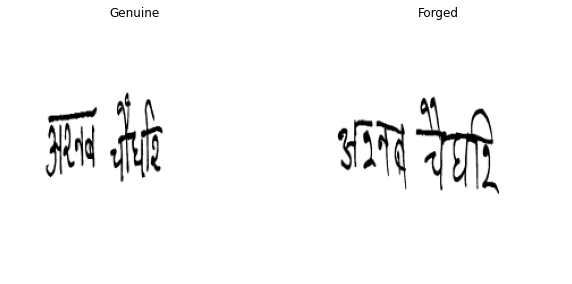

1/1 [==============================] - 0s 23ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(10)

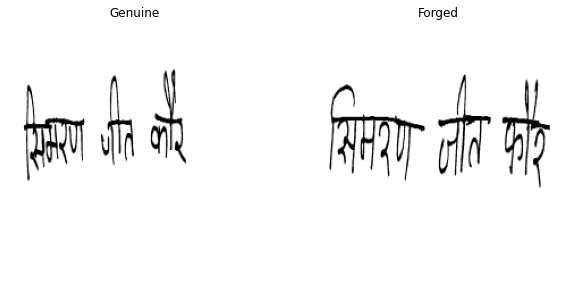

1/1 [==============================] - 0s 24ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(11)

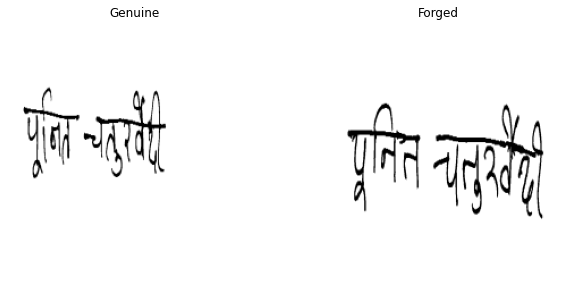

1/1 [==============================] - 0s 22ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(13)

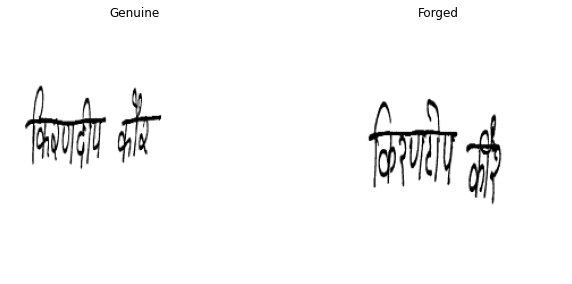

1/1 [==============================] - 0s 24ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(8)

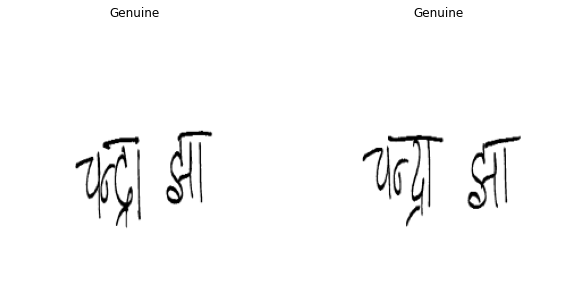

1/1 [==============================] - 0s 22ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(19)

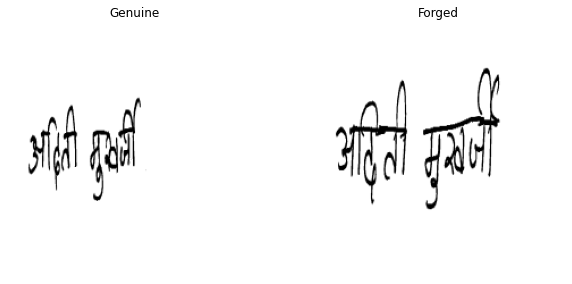

1/1 [==============================] - 0s 23ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(20)

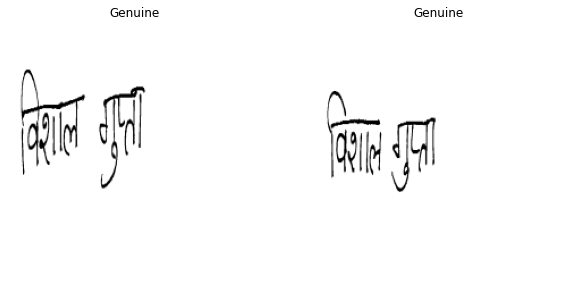

1/1 [==============================] - 0s 23ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(12)

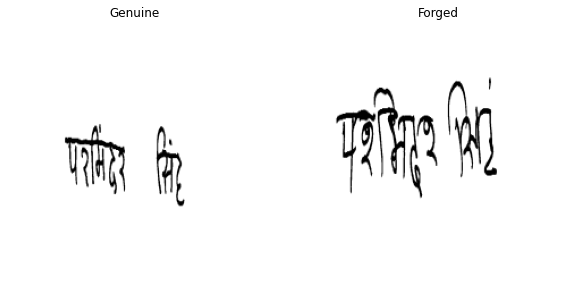

1/1 [==============================] - 0s 24ms/step
Difference Score =  0.99999774
Its a Forged Signature


In [ ]:
predict_score(15)

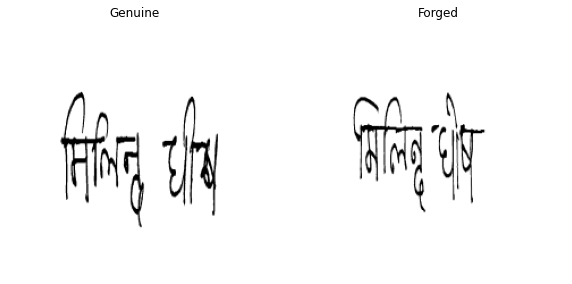

1/1 [==============================] - 0s 28ms/step
Difference Score =  0.9999939
Its a Forged Signature


In [ ]:
predict_score(16)

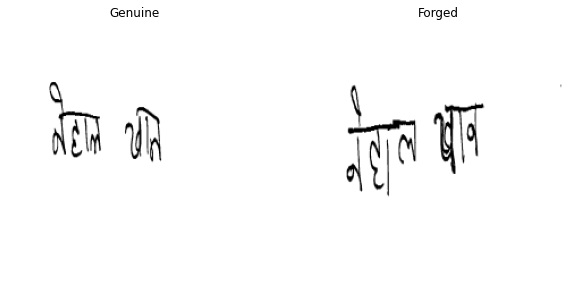

1/1 [==============================] - 0s 74ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(30)

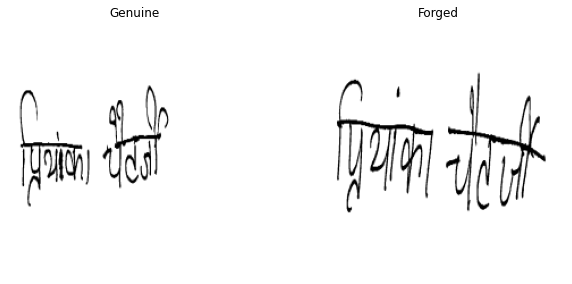

1/1 [==============================] - 0s 40ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

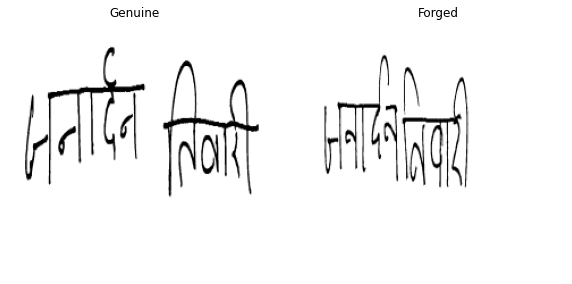

1/1 [==============================] - 0s 27ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

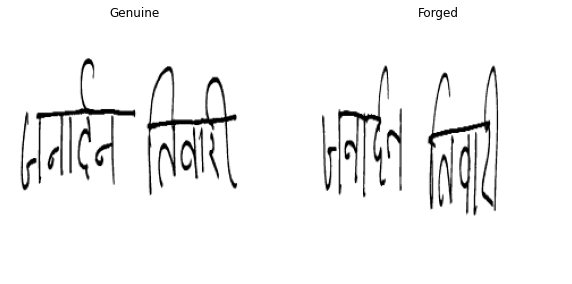

1/1 [==============================] - 0s 29ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

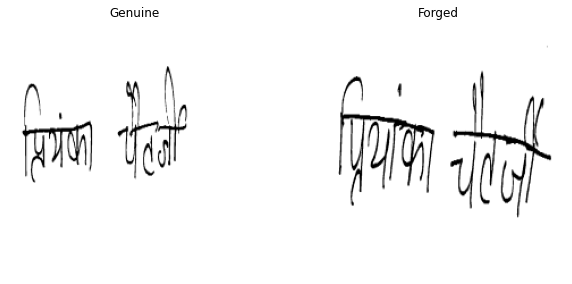

1/1 [==============================] - 0s 27ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

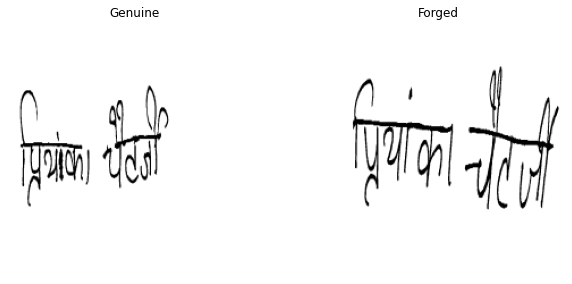

1/1 [==============================] - 0s 29ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

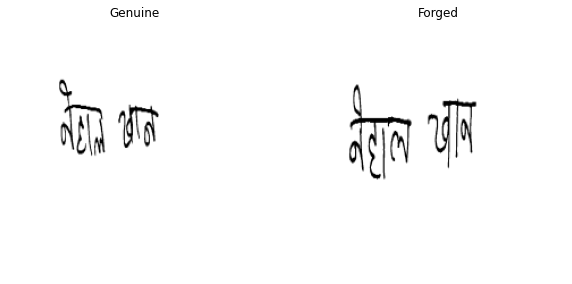

1/1 [==============================] - 0s 58ms/step
Difference Score =  0.99999815
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

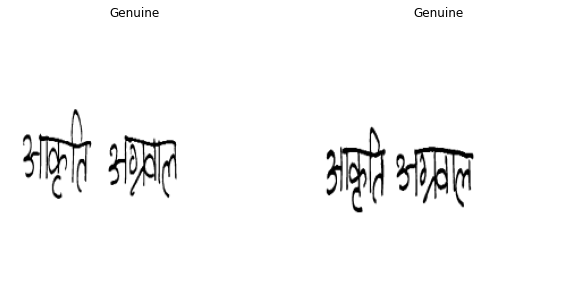

1/1 [==============================] - 0s 69ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

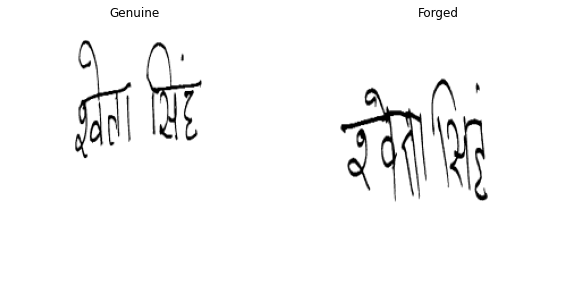

1/1 [==============================] - 0s 109ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

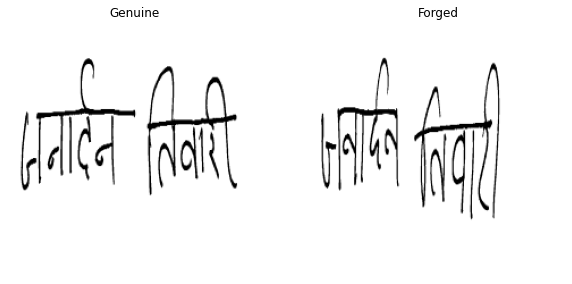

1/1 [==============================] - 0s 41ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

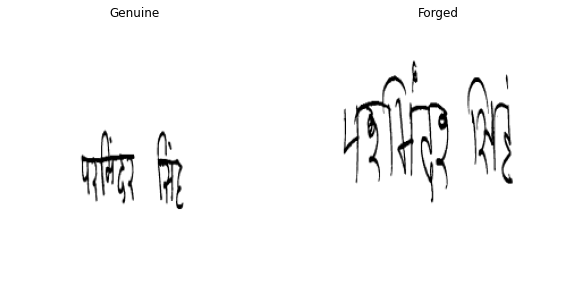

1/1 [==============================] - 0s 27ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

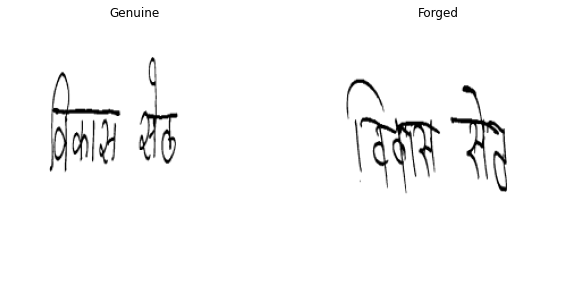

1/1 [==============================] - 0s 27ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

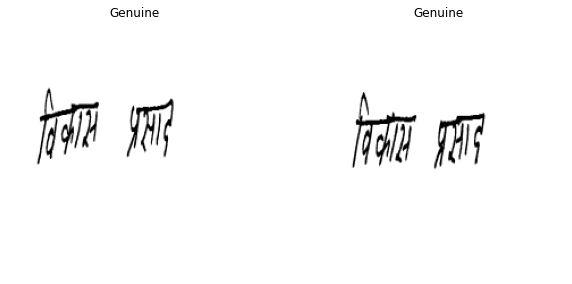

1/1 [==============================] - 0s 48ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

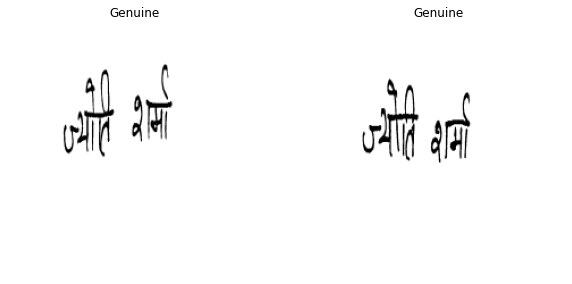

1/1 [==============================] - 0s 27ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

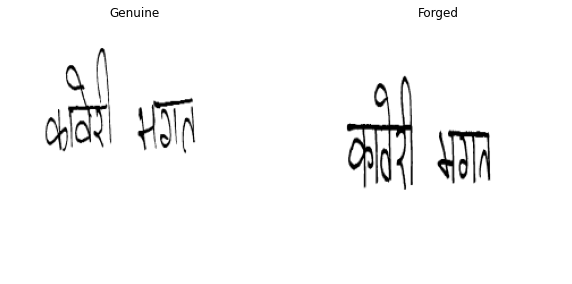

1/1 [==============================] - 0s 29ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

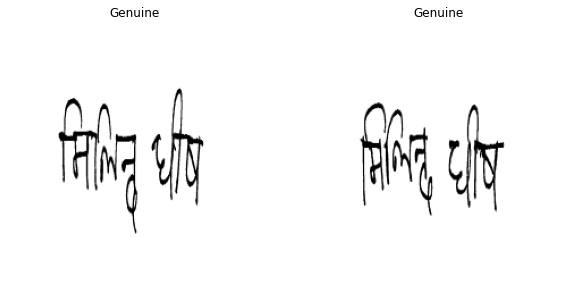

1/1 [==============================] - 0s 28ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

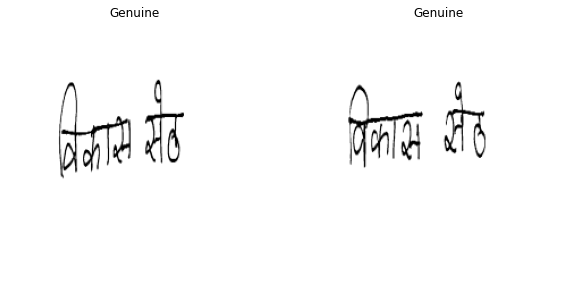

1/1 [==============================] - 0s 25ms/step
Difference Score =  0.00031622776
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

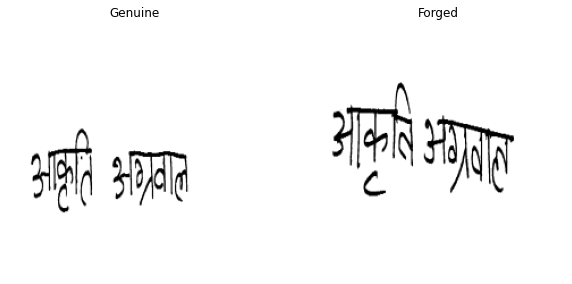

1/1 [==============================] - 0s 28ms/step
Difference Score =  1.0
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))